In [1]:
%load_ext autoreload
%autoreload 2

from cluster_g_logit_init_acceptpsi_flatlam_healthtoo import *



In [2]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_92305/1184199116.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [3]:

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, n_samples=10000,seed=1)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data


Original shapes: Y=torch.Size([407878, 348, 52]), E=torch.Size([407878, 348]), G=torch.Size([407878, 36])
New shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=torch.Size([10000, 36])


In [4]:
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_92305/1949801412.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt

In [5]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


In [17]:
# Load references (signatures only, no healthy)
refs = torch.load('reference_trajectories.pt')
signature_refs = refs['signature_refs']

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_var_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=3,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=None,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(4)
np.random.seed(4)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_92305/4144692232.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('reference_trajectories.pt'

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 6 diseases
Cluster 2: 13 diseases
Cluster 3: 97 diseases
Cluster 4: 22 diseases
Cluster 5: 22 diseases
Cluster 6: 15 diseases
Cluster 7: 17 diseases
Cluster 8: 35 diseases
Cluster 9: 6 diseases
Cluster 10: 13 diseases
Cluster 11: 9 diseases
Cluster 12: 11 diseases
Cluster 13: 6 diseases
Cluster 14: 17 diseases
Cluster 15: 5 diseases
Cluster 16: 15 diseases
Cluster 17: 8 diseases
Cluster 18: 17 diseases
Cluster 19: 3 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 11
Base value (first 5): tensor([-18.4207, -17.1035, -15.7863, -18.4207, -18.4207])
Base value centered (first 5): tensor([-0.3847,  0.9324,  2.2496, -0.3847, -0.3847])
Base value centered mean: 4.0349959817831405e-07
Gamma init for k=0 (first 5): tensor([ 0.0017,  0.0129, -0.0278, -0.0078,  0.0008])

Calculating gamma for k=1:
Number of diseases in cluster: 6
Base value (fi

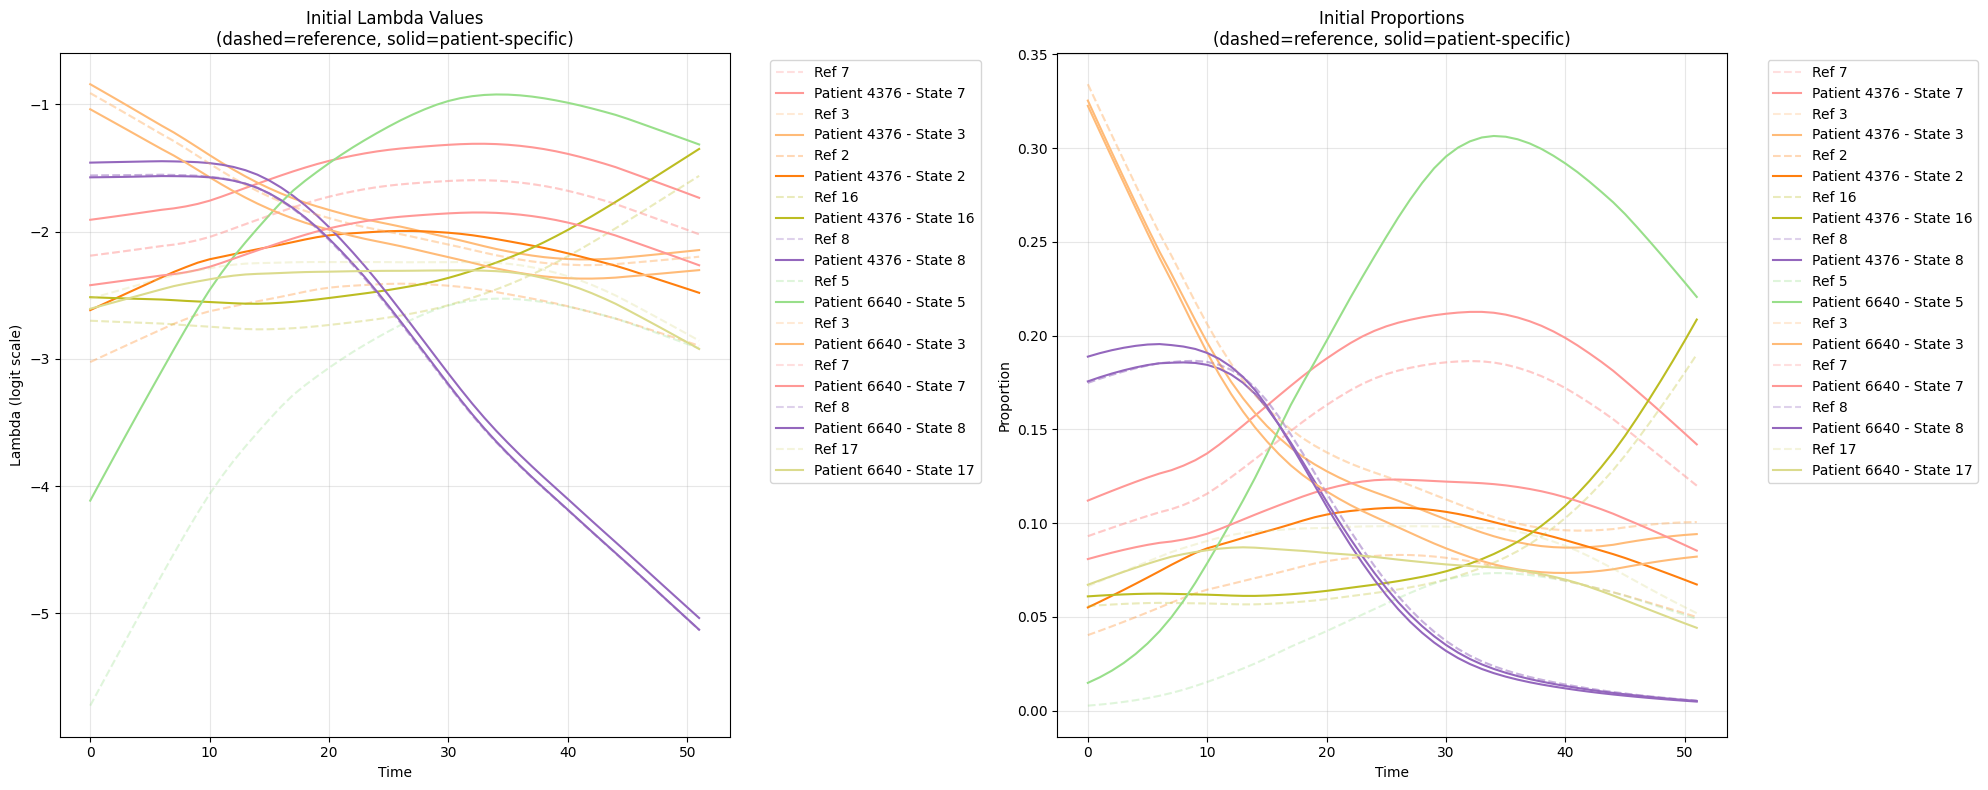


Genetic Effect Statistics for Sample Patients:

Patient 4376:
Mean shift: 0.063
Std of shifts: 0.297
Range of shifts: [-0.770, 0.546]

Top states and average proportions:
State 7: 0.173
State 3: 0.143
State 2: 0.090
State 16: 0.089
State 8: 0.086

Patient 6640:
Mean shift: 0.002
Std of shifts: 0.396
Range of shifts: [-0.313, 1.612]

Top states and average proportions:
State 5: 0.197
State 3: 0.132
State 7: 0.107
State 8: 0.087
State 17: 0.075


In [18]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        ref_props = torch.softmax(signature_refs, dim=0)[k]
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')

# Customize plots
ax1.set_title('Initial Lambda Values\n(dashed=reference, solid=patient-specific)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Initial Proportions\n(dashed=reference, solid=patient-specific)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects for these patients
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]  # Already computed above
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")

In [19]:
model.genetic_scale

3

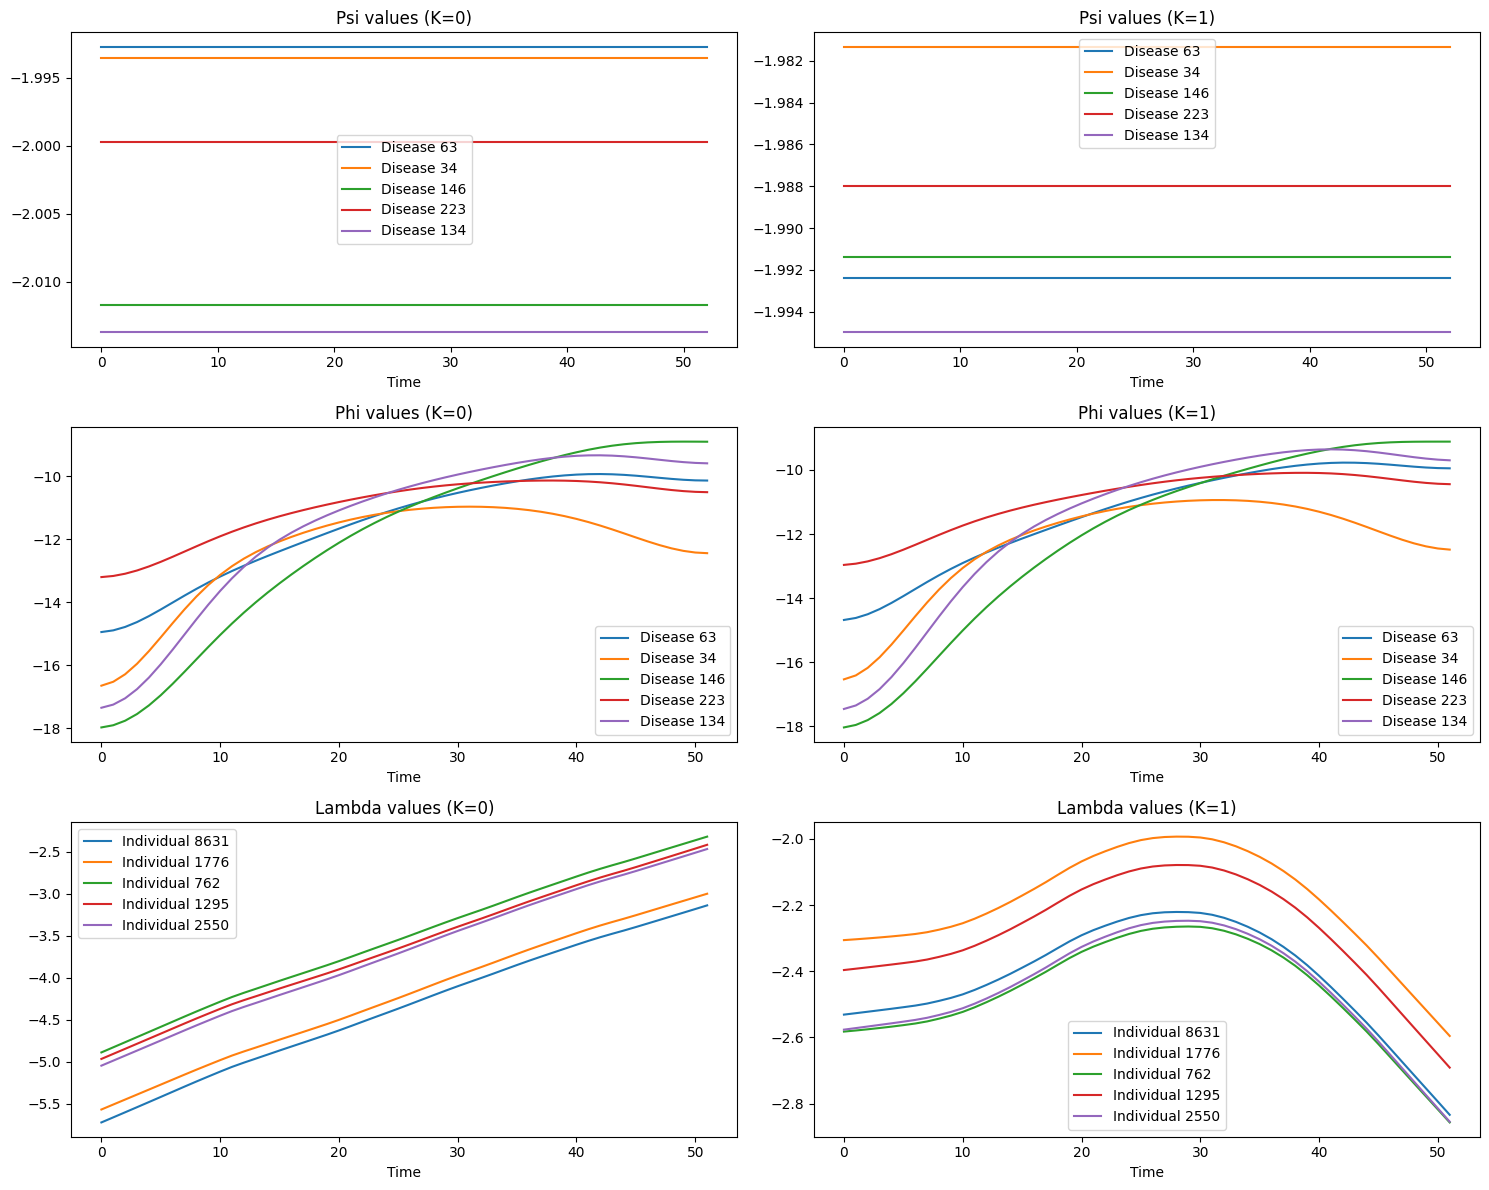


Cluster membership for sampled diseases:
Disease 63: Cluster 16
Disease 34: Cluster 3
Disease 146: Cluster 16
Disease 223: Cluster 3
Disease 134: Cluster 11

Cluster Assignments:

Cluster 0:
  - Rheumatic disease of the heart valves (prevalence: 0.0002)
  - Mitral valve disease (prevalence: 0.0003)
  - Aortic valve disease (prevalence: 0.0001)
  - Disease of tricuspid valve (prevalence: 0.0003)
  - Other forms of chronic heart disease (prevalence: 0.0004)
  - Cardiomegaly (prevalence: 0.0005)
  - Pericarditis (prevalence: 0.0001)
  - Primary/intrinsic cardiomyopathies (prevalence: 0.0001)
  - Left bundle branch block (prevalence: 0.0003)
  - Paroxysmal supraventricular tachycardia (prevalence: 0.0002)
  - Paroxysmal ventricular tachycardia (prevalence: 0.0001)
  - Atrial fibrillation and flutter (prevalence: 0.0009)
  - Congestive heart failure (CHF) NOS (prevalence: 0.0003)
  - Heart failure NOS (prevalence: 0.0007)
  - Pleurisy; pleural effusion (prevalence: 0.0008)
  - Congenital a

In [20]:
model.plot_initial_params()
# Convert disease names to list if it's not already
disease_names_list = list(essentials['disease_names'])

# Now visualize clusters
model.visualize_clusters(disease_names=disease_names_list)

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:841: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


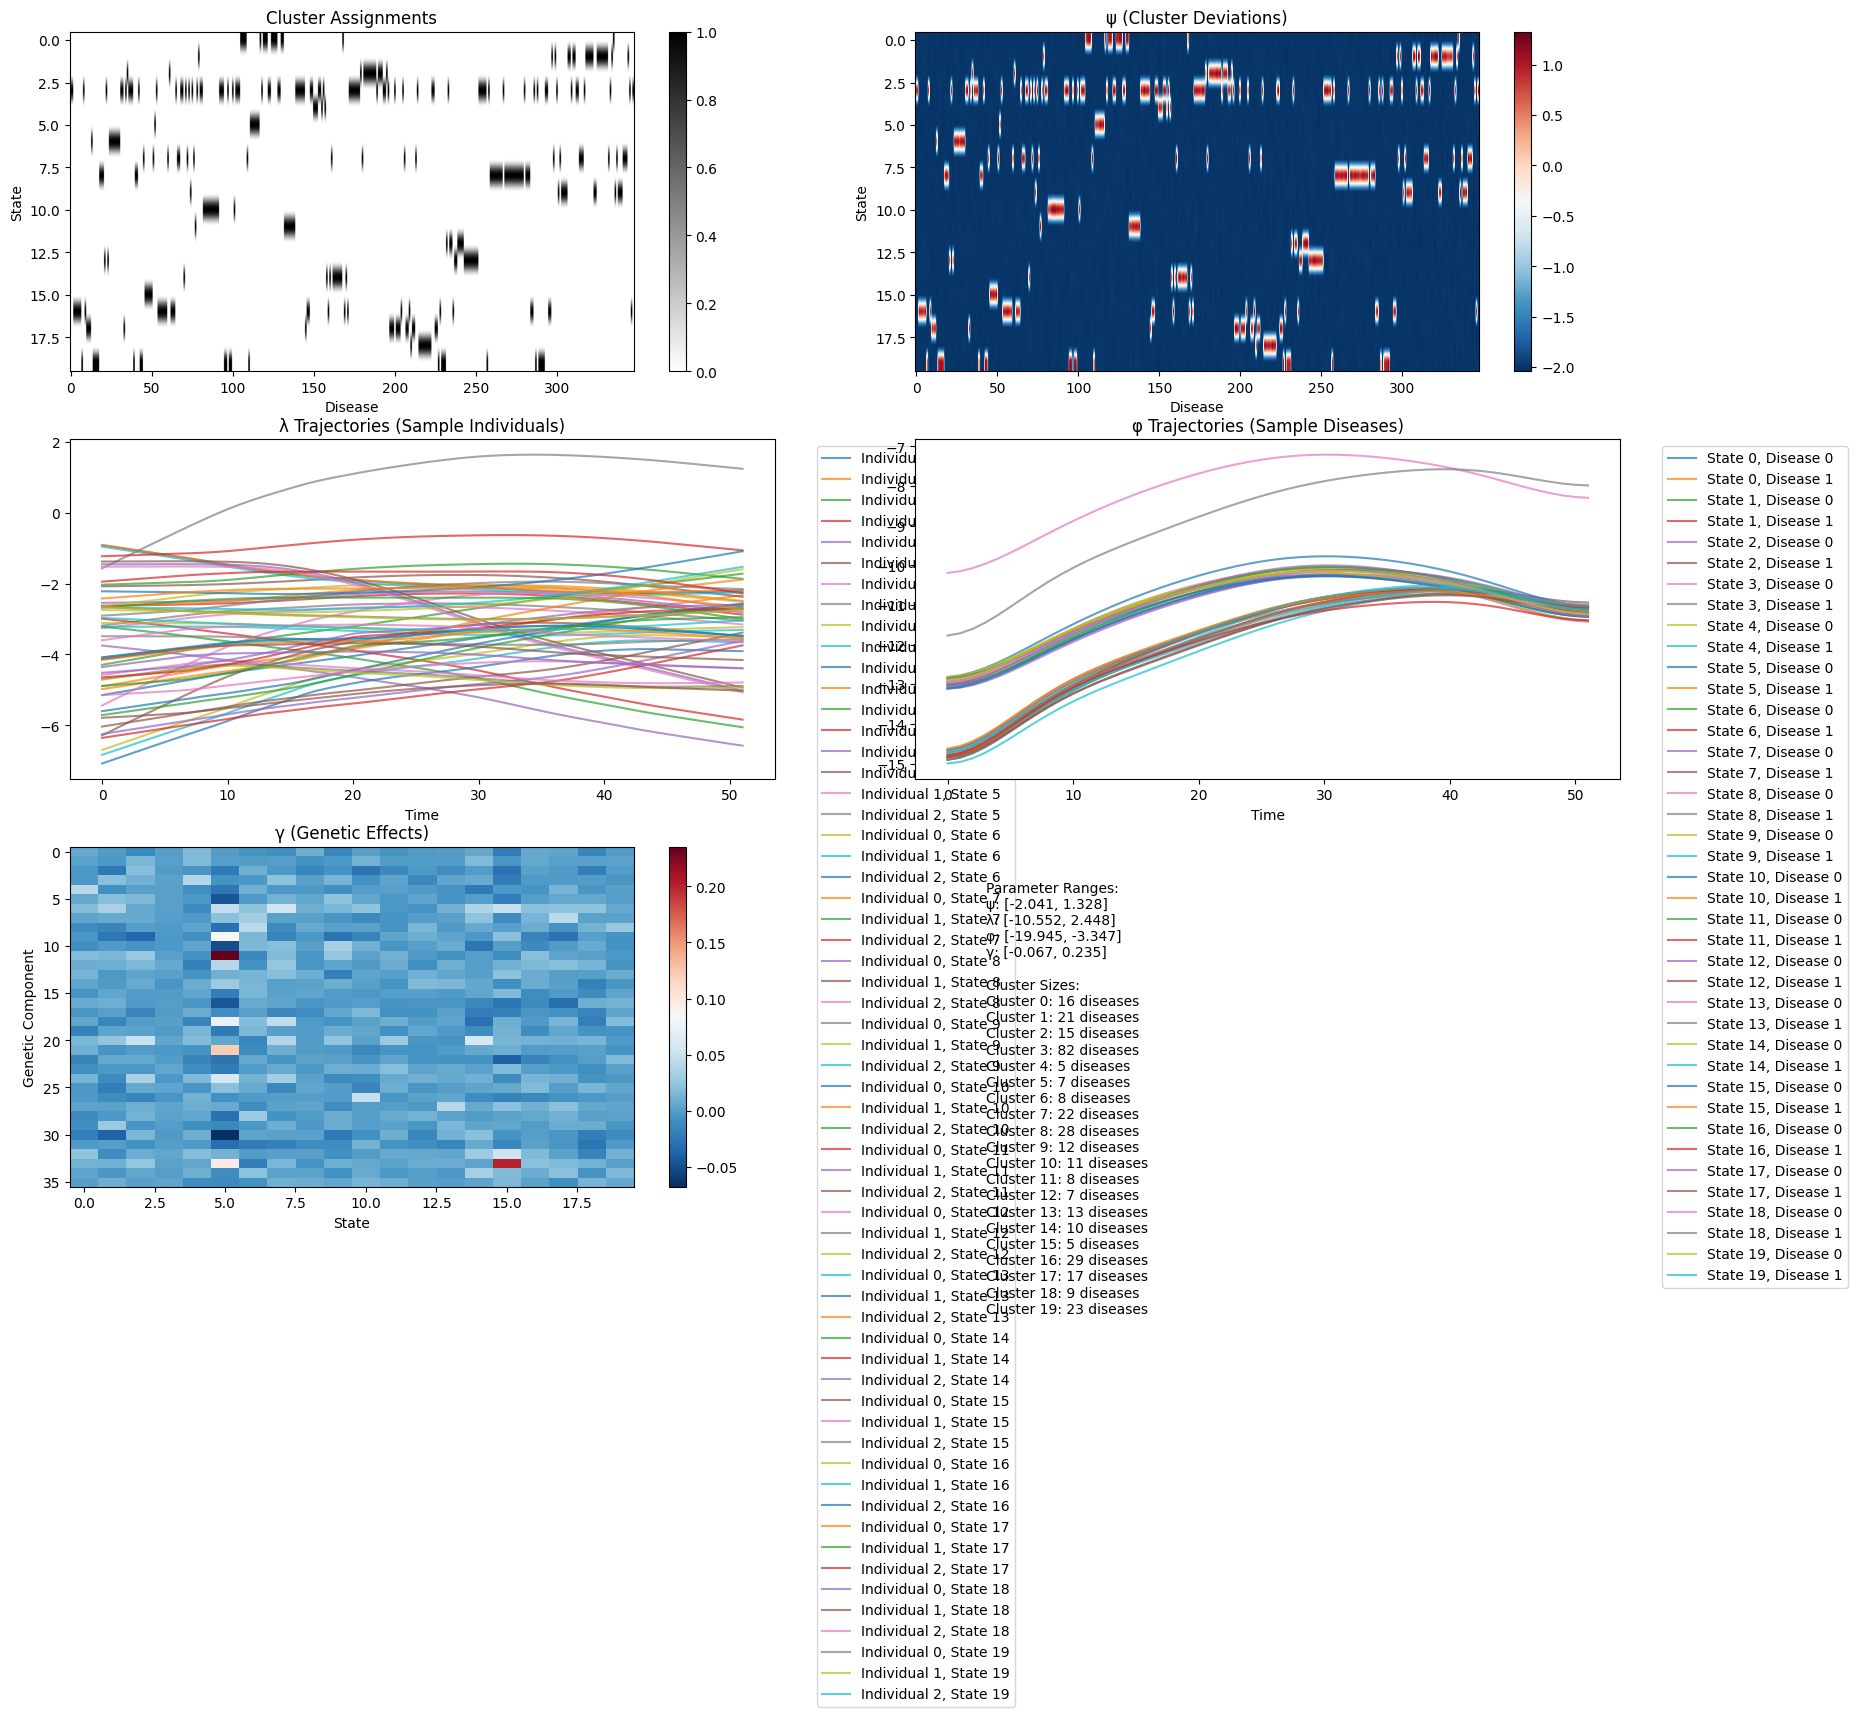

In [21]:
model.visualize_initialization()

In [22]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()


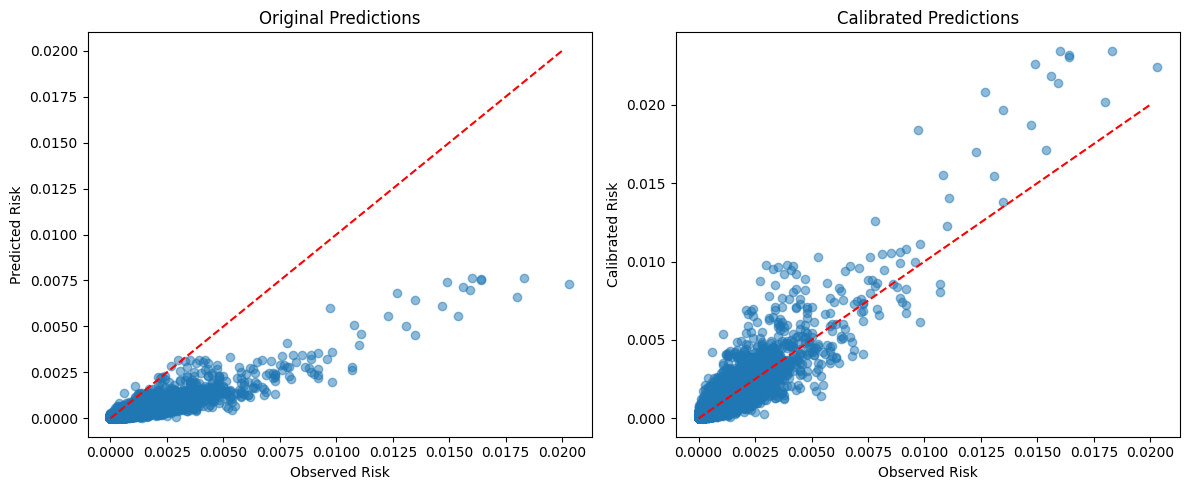

Mean observed risk: 0.000439
Mean predicted risk (original): 0.000143
Mean predicted risk (calibrated): 0.000439
Calibration scale factor: 3.060


In [23]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [24]:
ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.770


In [ ]:

history_new = model.fit(E_100k, num_epochs=100, learning_rate=1e-4, lambda_reg=1e-2)
        

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi_flatlam_healthtoo.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 0
Loss: 71.1071
Psi gradient stats:
Mean: -2.2656e-06
Std:  4.7114e-04
Max:  1.6239e-03
Min:  -1.6250e-03
Epoch 0, Loss: 71.1071, Gradients - Lambda: 5.345e-03, Phi: 1.283e+00, Gamma: 1.989e-03, Psi: 1.625e-03
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 1
Loss: 71.0216
Psi gradient stats:
Mean: -2.2636e-06
Std:  4.7105e-04
Max:  1.6242e-03
Min:  -1.6257e-03
Epoch 1, Loss: 71.0216, Gradients - Lambda: 5.089e-03, Phi: 1.278e+00, Gamma: 1.926e-03, Psi: 1.626e-03

Estimated total training time: 52.2 minutes
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 2
Loss: 70.2428
Psi gradient stats:
Mean: -2.3222e-06
Std:  4.7013e-04
Max:  1.6282e-03
Min:  -1.6280e-03
Epoch 2, Loss: 70.2428, Gradients - Lambda: 3.826e-03, Phi: 1.229e+00, Gamma: 1.236e-03, Psi: 1.

In [47]:
final_lambda = model.lambda_.detach().clone()
diff = torch.abs(final_lambda - initial_lambda)

print(f"Lambda changes with lr=1e-4:")
print(f"Mean absolute change: {torch.mean(diff):.3e}")
print(f"Max absolute change: {torch.max(diff):.3e}")
print(f"Std of changes: {torch.std(diff):.3e}")

Lambda changes with lr=1e-4:
Mean absolute change: 2.034e-05
Max absolute change: 1.512e-03
Std of changes: 2.017e-05


In [49]:
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


Clusters match exactly: True


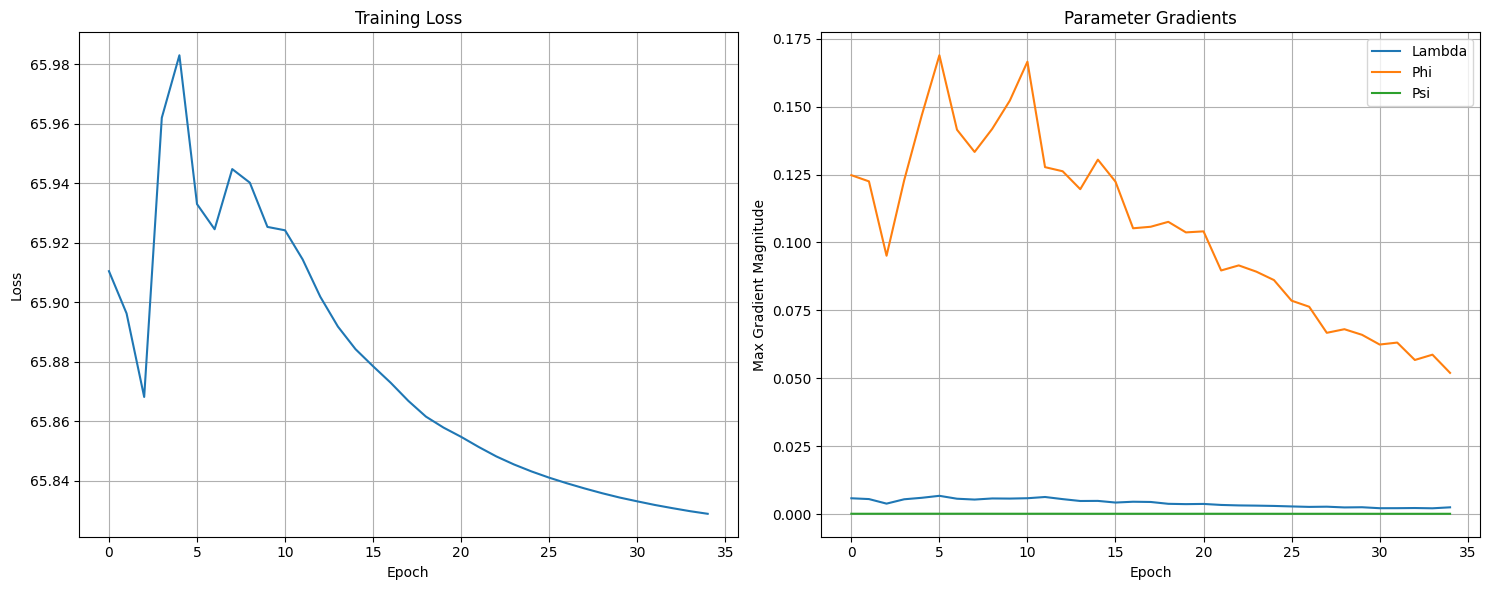

In [50]:

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history_new['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history_new['max_grad_lambda'], label='Lambda')
ax2.plot(history_new['max_grad_phi'], label='Phi')
ax2.plot(history_new['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

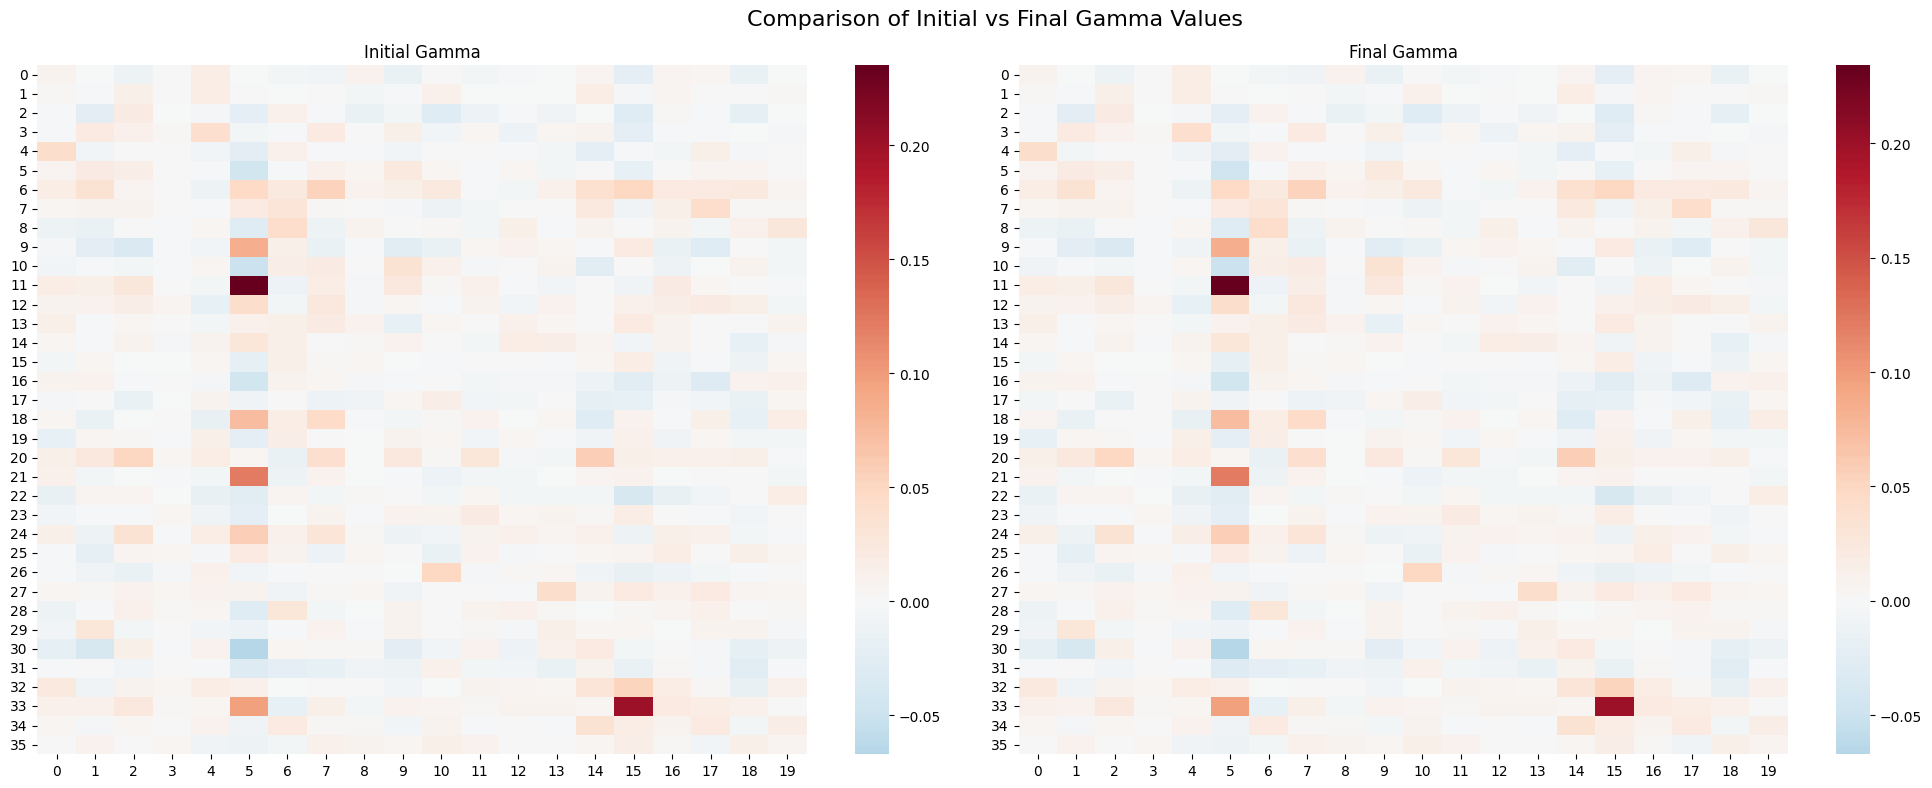

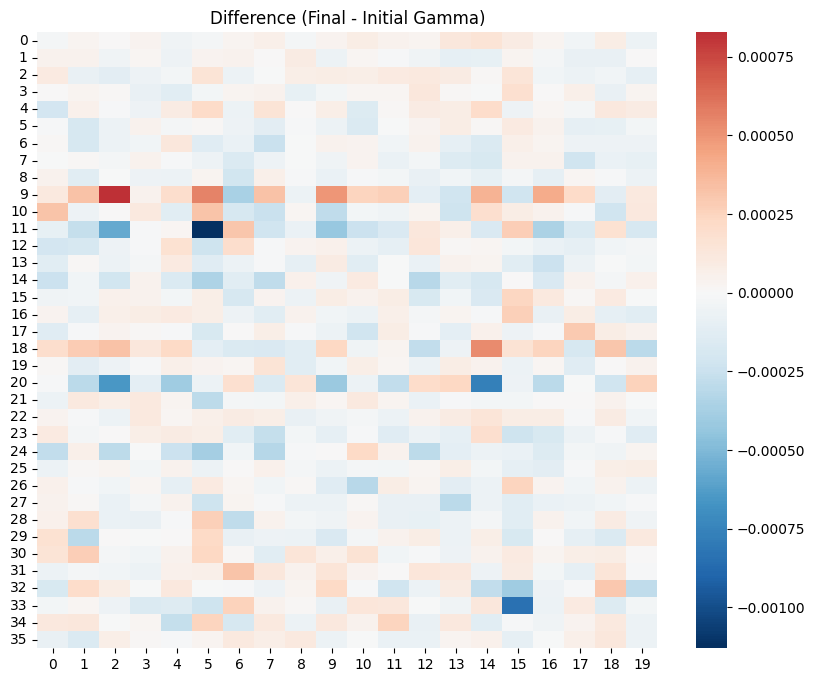

Mean absolute difference: 0.0001
Max absolute difference: 0.0011
Standard deviation of differences: 0.0001


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert gamma tensors to numpy arrays
initial_gamma_np = initial_gamma.detach().numpy()
final_gamma_np = model.gamma.detach().numpy()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial gamma
sns.heatmap(initial_gamma_np, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Gamma')

# Plot final gamma
sns.heatmap(final_gamma_np, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Gamma')

# Add a title to the figure
plt.suptitle('Comparison of Initial vs Final Gamma Values', fontsize=16)

# You can also add a colorbar
plt.tight_layout()

# To see the actual difference, you can also create a difference heatmap
plt.figure(figsize=(10, 8))
diff = final_gamma_np - initial_gamma_np
sns.heatmap(diff, cmap='RdBu_r', center=0)
plt.title('Difference (Final - Initial Gamma)')
plt.show()

# Print some summary statistics
print(f"Mean absolute difference: {np.abs(diff).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff):.4f}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert phi tensors to numpy arrays
initial_phi_np = initial_phi.detach().numpy()  # Shape: (K, D, T)
final_phi_np = model.phi.detach().numpy()

# Take mean over time dimension
initial_phi_mean = initial_phi_np.mean(axis=2)  # Shape: (K, D)
final_phi_mean = final_phi_np.mean(axis=2)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial phi (averaged over time)
sns.heatmap(initial_phi_mean, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Phi (Mean over Time)')
ax1.set_xlabel('Disease')
ax1.set_ylabel('Signature')

# Plot final phi (averaged over time)
sns.heatmap(final_phi_mean, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Phi (Mean over Time)')
ax2.set_xlabel('Disease')
ax2.set_ylabel('Signature')

plt.suptitle('Comparison of Initial vs Final Phi Values (Averaged over Time)', fontsize=16)
plt.tight_layout()

# Plot difference
plt.figure(figsize=(10, 8))
diff_mean = final_phi_mean - initial_phi_mean
sns.heatmap(diff_mean, cmap='RdBu_r', center=0)
plt.title('Difference in Phi (Final - Initial), Mean over Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

# Print summary statistics for both full tensor and time-averaged differences
print("Full tensor statistics:")
diff_full = final_phi_np - initial_phi_np
print(f"Mean absolute difference: {np.abs(diff_full).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_full).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_full):.4f}")

print("\nTime-averaged statistics:")
print(f"Mean absolute difference: {np.abs(diff_mean).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_mean).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_mean):.4f}")

# Optionally, look at temporal variation
temporal_std = np.std(diff_full, axis=2)
plt.figure(figsize=(10, 8))
sns.heatmap(temporal_std, cmap='viridis')
plt.title('Standard Deviation of Changes Across Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

In [233]:
model_save_path='/Users/sarahurbut/Dropbox (Personal)/model_with_poptrajectory_lr1e-3.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'initial_phi': initial_phi, 
    'initial_lambda': initial_lambda, 
    'psi': model.psi,
    'Y': Y_100k,
    'prevalence_t': essentials['prevalence_t'],
    'logit_prevalence_t': model.logit_prev_t,
    'G': G_100k,
    'E': E_100k,
    'indices': indices,
    'disease_names': disease_names,
    'hyperparameters': {
        'N': Y_100k.shape[0],
        'D': Y_100k.shape[1],
        'T': Y_100k.shape[2],
        'P': G_100k.shape[1],
        'K': model.phi.shape[0]
    }
}, model_save_path)



In [ ]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [ ]:

ss_res = np.sum((observed_risk - predicted_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

In [ ]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])

In [ ]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])

In [ ]:
def plot_signature_temporal_patterns(model, disease_names, n_top=10, selected_signatures=None):
    """
    Show temporal patterns of top diseases for each signature
    """
    #phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    #phi_avg = phi.mean(axis=2)  # Average over time

     # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Select which signatures to plot
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    # Create subplots for each selected signature
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        # Get top diseases
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        # Plot temporal patterns
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            ax.plot(temporal_pattern, label=disease_names[idx])
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# First show the top diseases


# Then show their temporal patterns
# You can select specific signatures of interest:
disease_names=essentials['disease_names']
plot_signature_temporal_patterns(model, disease_names, selected_signatures=[0,1,14,15,16,13,17])

In [35]:
Y_avg_global = torch.mean(torch.tensor(Y) if isinstance(Y,np.ndarray) else Y, dim=2)
Y_avg_batch = torch.mean(torch.tensor(Y_100k) if isinstance(Y_100k, np.ndarray) else Y_100k, dim=2)


In [ ]:
def compare_disease_patterns(k, true_psi, Y_avg_global, Y_avg_batch):
    """Compare disease patterns between global and batch data"""
    strong_diseases = (true_psi[k] > 0)
    
    # Get mean pattern for each dataset (average across patients)
    pattern_large = Y_avg_global[:, strong_diseases].mean(dim=0)  # Average across all patients
    pattern_small = Y_avg_batch[:, strong_diseases].mean(dim=0)  # Average across batch patients
    
    # Now both patterns are just length of strong_diseases
    correlation = torch.corrcoef(
        torch.stack([pattern_large, pattern_small])
    )[0,1]
    
    print(f"Signature {k} pattern correlation: {correlation:.3f}")
    print(f"Mean pattern difference: {(pattern_large - pattern_small).abs().mean():.3f}")

# Now use it
print("Comparing disease sharing patterns between global and batch data:")
for k in range(model.K):
    print(f"\nSignature {k}:")
    compare_disease_patterns(k, model.psi, Y_avg_global, Y_avg_batch)

In [ ]:
# Sample patients and set parameters
n_samples = 2
sample_patients = [4376, 6640]  # Use specific patients
n_top_states = 5  # Show only top 5 states per patient

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
time_points = np.arange(model.T)

# Get dominant states for these patients
lambda_patients = model.lambda_[sample_patients]  # [2, K, T]
patient_props = torch.softmax(lambda_patients, dim=1)  # [2, K, T]
mean_props = patient_props.mean(dim=-1)  # Average over time, now [2, K]
top_states = mean_props.topk(n_top_states, dim=-1).indices  # Get top states for each patient

# Color map for consistent colors across patients
colors = plt.cm.tab20(np.linspace(0, 1, model.K))

# Plot for each patient
for i, patient in enumerate(sample_patients):
    for j, k in enumerate(top_states[i]):
        k = k.item()  # Convert tensor to int
        color = colors[k]
        
        # Plot lambda values
        ax1.plot(time_points, signature_refs[k], '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax1.plot(time_points, model.lambda_[patient, k].detach(), '-', color=color,
                label=f'Patient {patient} - State {k}')
        
        # Plot proportions
        ref_props = torch.softmax(signature_refs, dim=0)[k]
        patient_props = torch.softmax(model.lambda_[patient].detach(), dim=0)[k]
        ax2.plot(time_points, ref_props, '--', color=color, alpha=0.3, 
                label=f'Ref {k}')
        ax2.plot(time_points, patient_props, '-', color=color,
                label=f'Patient {patient} - State {k}')

# Customize plots
ax1.set_title('Final Lambda Values\n(dashed=reference, solid=patient-specific)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Lambda (logit scale)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_title('Final Proportions\n(dashed=reference, solid=patient-specific)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Proportion')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print genetic effects for these patients
print("\nGenetic Effect Statistics for Sample Patients:")
for i, patient in enumerate(sample_patients):
    genetic_effects = model.genetic_scale * (model.G[patient] @ model.gamma).detach()
    print(f"\nPatient {patient}:")
    print(f"Mean shift: {genetic_effects.mean():.3f}")
    print(f"Std of shifts: {genetic_effects.std():.3f}")
    print(f"Range of shifts: [{genetic_effects.min():.3f}, {genetic_effects.max():.3f}]")
    
    # Print top states and their proportions
    patient_mean_props = mean_props[i]  # Already computed above
    top_props, top_indices = patient_mean_props.topk(n_top_states)
    print("\nTop states and average proportions:")
    for state, prop in zip(top_indices, top_props):
        print(f"State {state.item()}: {prop:.3f}")